# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    453      0 --:--:-- --:--:-- --:--:--   452
100 1546k  100 1546k    0     0   953k      0  0:00:01  0:00:01 --:--:-- 9152k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    803      0 --:--:-- --:--:-- --:--:--   801
100  385k  100  385k    0     0   367k      0  0:00:01  0:00:01 --:--:--  367k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    780      0 --:--:-- --:--:-- --:--:--   779
100  230k  100  230k    0     0   227k      0  0:00:01  0:00:01 --:--:--  227k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1 MB 7.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606550 sha256=9d3ccc3bd1469359e25d8c2b6857dddf6f3e636d1ce2a63d200dac06b60ab7a9
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [26]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [12]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [20]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [14]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [15]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [16]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** Lo que tenemos como data es una matriz de interacciones de nxm, con n siendo los usuarios y m siendo los items (pueden ser canciones, películas, etc). A nosotros nos gustaría separar esta matriz en una multiplicación de dos vectores, los cuales representarían un vector de usuarios y otro vector de canciones. En el algoritmo de ALS, lo que se busca son los valores de estos vectores (actualizándolos de manera alterna) para encontrar la mejor aproximación de la matriz original (la mejor aproximación se refiere al error más bajo encontrado).

In [17]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [18]:
show_recommendations(model_als, user=77, n=10)

movieid
754                                     Red Corner (1997)
256     When the Cats Away (Chacun cherche son chat) (...
292                                       Rosewood (1997)
258                                        Contact (1997)
125                                     Phenomenon (1996)
1012                                 Private Parts (1997)
409                                           Jack (1996)
248                            Grosse Pointe Blank (1997)
240                Beavis and Butt-head Do America (1996)
242                                          Kolya (1996)
Name: title, dtype: object

In [27]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06106453075763269
ndcg: 0.333843797856049


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [28]:
# importamos las librerias necesarias para crear gráficos
import matplotlib.pyplot as plt

Primero vamos a crear distintos modelos de ALS variando el valor de factors, o sea, la cantidad de factores latentes.

In [41]:
latent_factors = [150, 300, 500, 1000, 1500, 2000]

map_values = []
ndcg_values = []

for f in latent_factors:
  model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=False)
  model_als.fit(matrix)

  maprec, ndcg = evaluate_model(model_als, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Al probar con distintos valores, podemos encontrar que el valor de factores óptimo es 1000, ahí el MAP y el nDGC se hacen mínimos. Un problema que se dió fue que al aumentar la cantidad de factores latentes entonces el tiempo necesario para entrenarlo tambien aumentaba, por lo hay que considerar esto antes de elegir un valor demasiado elevado (queremos que nuestro modelo sea preciso al igual que rápido en ejecución).

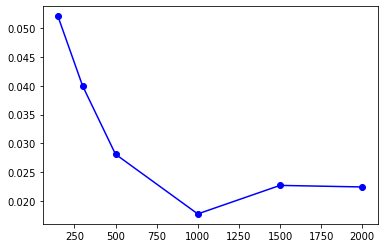

In [43]:
plt.plot(latent_factors, map_values, 'b-')
plt.plot(latent_factors, map_values, 'bo')
plt.show()

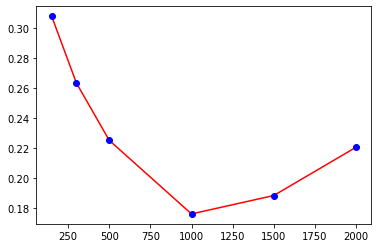

In [42]:
plt.plot(latent_factors, ndcg_values, 'r-')
plt.plot(latent_factors, ndcg_values, 'bo')
plt.show()

Ahora vamos a variar los valores de la variable iterations, el cual es al cantidad de iteraciones que se van a usar para entrenar el modelo.

In [99]:
iter_factors = [10, 50, 150, 200, 500, 700]

map_values = []
ndcg_values = []

for i in iter_factors:
  model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=i, use_gpu=False)
  model_als.fit(matrix)

  maprec, ndcg = evaluate_model(model_als, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

Al igual que la otra variable, al aumentar la cantidad de iteraciones entonces vamos a aumetar el tiempo de demora para entrenar nuestro modelo. Se puede ver en los gráficos de error MAP y nDCG que la cantidad de iteraciones que los minimiza se 150. Pero si no consideramos la forma de los gráficos, y nos centramos en los valores que nos entregan, vemos que estos se mueven en un rango muy pequeño: MAP tiene una diferencia de 0.004 entre el máximo error y el mínimo; nDCG tiene una diferencia de 0.013. Cuando cambiábamos la cantidad de factores latentes, la diferencia de error que se daba era casi 10 veces más grande a comparacion de cuando solamente cambiábamos la cantidad de variaciones.

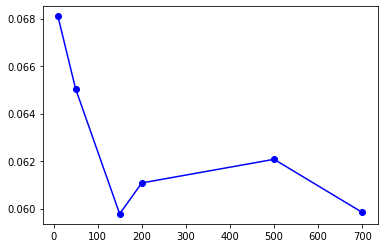

0.003049585221041304

In [100]:
plt.plot(iter_factors, map_values, 'b-')
plt.plot(iter_factors, map_values, 'bo')
plt.show()
map_values[0] - map_values[1]

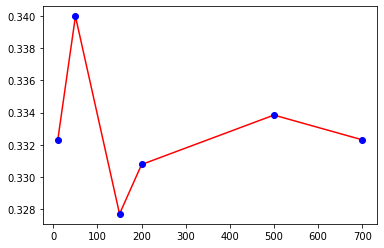

-0.01225114854517606

In [101]:
plt.plot(iter_factors, ndcg_values, 'r-')
plt.plot(iter_factors, ndcg_values, 'bo')
plt.show()
ndcg_values[2] - ndcg_values[1]

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

**Respuesta:** El framework BPR es un método usado para aprender a rankear. Este necesita 3 atributos importantes: el modelo que se va a usar, la función de pérdida que se va a seguir para encontrar el mínimo y el aprendizaje. \\
Cuando hablamos de ranking, nos referimos a una tripleta [user, item i, item j] en el cual nos dice si el usuario user prefiere al item i sobre al item j. Esto nos lleva a una matriz de mxm (m items) para cada usuario en el cual nos dice si el item j es preferido sobre el item i por el usuario.

In [61]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

  0%|          | 0/40 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [62]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257                               Men in Black (1997)
746                                Real Genius (1985)
285                             Secrets & Lies (1996)
299                                    Hoodlum (1997)
332                             Kiss the Girls (1997)
301                                   In & Out (1997)
312    Midnight in the Garden of Good and Evil (1997)
327                                   Cop Land (1997)
244                     Smilla's Sense of Snow (1997)
300                              Air Force One (1997)
Name: title, dtype: object

In [63]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
173         Princess Bride, The (1987)
68                    Crow, The (1994)
203                  Unforgiven (1992)
172    Empire Strikes Back, The (1980)
78                   Free Willy (1993)
194                  Sting, The (1973)
201                Evil Dead II (1987)
175                      Brazil (1985)
Name: title, dtype: object

In [64]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05522227558417201
ndcg: 0.3614088820826952


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

Para empezar, vamos a iterar sobre diferente valores de factores latentes.

In [110]:
factor_values = [200, 300, 400, 500, 600]
map_values = []
ndcg_values = []

for f in factor_values:
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)

  maprec, ndcg = evaluate_model(model_bpr, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Al mirar los diferentes errores que nos dan los gráficos, podemos ver que la cantidad de factores latentes que los hace mínimo es 300.

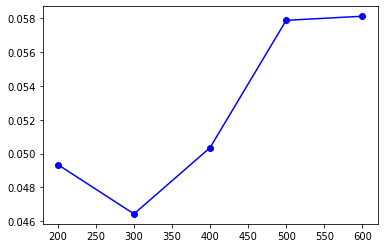

In [111]:
plt.plot(factor_values, map_values, 'b-')
plt.plot(factor_values, map_values, 'bo')
plt.show()

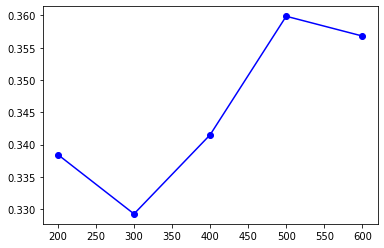

In [112]:
plt.plot(factor_values, ndcg_values, 'b-')
plt.plot(factor_values, ndcg_values, 'bo')
plt.show()

Ahora vamos a probar BPR con diferentes valores de iteraciones.

In [105]:
iterations_values = [30, 40, 50 ,60]
map_values = []
ndcg_values = []

for i in iterations_values:
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=i, use_gpu=False)
  model_bpr.fit(matrix)

  maprec, ndcg = evaluate_model(model_bpr, n=10)

  map_values.append(maprec)
  ndcg_values.append(ndcg)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Al mirar los gráficos de error, se puede ver que el valor de iteraciones que los hace mínimo es 50.

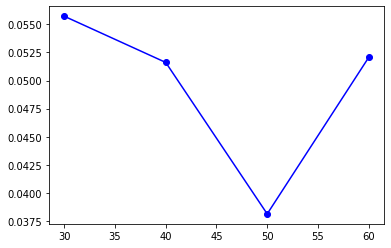

In [106]:
plt.plot(iterations_values, map_values, 'b-')
plt.plot(iterations_values, map_values, 'bo')
plt.show()

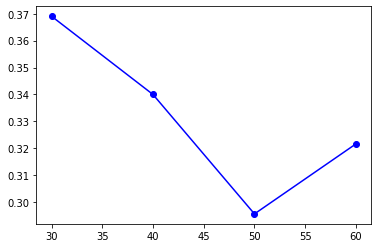

In [107]:
plt.plot(iterations_values, ndcg_values, 'b-')
plt.plot(iterations_values, ndcg_values, 'bo')
plt.show()